In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.spatial import Voronoi
from tyssue import Epithelium

from tyssue.core.generation import from_2d_voronoi
from tyssue import config
from tyssue.draw.threejs_draw import view_3js
from tyssue import SheetGeometry
from tyssue.core.objects import get_opposite
from tyssue.draw.plt_draw import quick_edge_draw  

from tyssue.draw.threejs_draw import edge_lines
import pythreejs as py3js

import seaborn as sns

import matplotlib as mpl

In [234]:
a, b, c = 170, 170, 250
epsilon = 1e-6

n_zs = 8
dist = c / (1.76*n_zs)
zs = np.linspace(-c+dist/2, c-dist/2, n_zs)

thetas = np.arcsin(zs/c)
av_rhos = (a + b) * np.cos(thetas) / 2
n_cells = np.ceil(av_rhos/dist).astype(np.int)

phis = np.concatenate(
    [np.linspace(-np.pi, np.pi, nc, endpoint=False)
     + (np.pi/nc) * (i%2) for i, nc in enumerate(n_cells)])
zs = np.concatenate(
    [z * np.ones(nc) for z, nc in zip(zs, n_cells)])
thetas = np.concatenate(
    [theta * np.ones(nc) for theta, nc in zip(thetas, n_cells)])

xs = a * np.cos(thetas) * np.cos(phis) + np.random.normal(scale=epsilon,
                                                          size=thetas.shape)
ys = b * np.cos(thetas) * np.sin(phis) + np.random.normal(scale=epsilon,
                                                          size=thetas.shape)
zs +=  np.random.normal(scale=epsilon, size=thetas.shape)
print(zs.shape)


(58,)


In [236]:
centers = pd.DataFrame.from_dict({'x': xs, 'y': ys, 'z': zs,
                                  'theta': thetas, 'phi': phis})

In [239]:
pbc_voro.ridge_dict

{(0, 3): [12, 13],
 (0, 4): [2, 13],
 (1, 0): [-1, 2],
 (1, 2): [-1, 6],
 (1, 4): [1, 2],
 (1, 5): [1, 7],
 (1, 6): [6, 7],
 (2, 6): [6, 50],
 (2, 8): [14, 48],
 (3, 4): [13, 159],
 (4, 12): [75, 163],
 (5, 4): [1, 74],
 (5, 13): [74, 76],
 (5, 14): [53, 76],
 (6, 5): [7, 53],
 (6, 14): [52, 53],
 (6, 15): [51, 52],
 (7, 2): [48, 50],
 (7, 6): [50, 51],
 (7, 8): [48, 49],
 (7, 15): [47, 51],
 (7, 16): [47, 49],
 (8, 17): [89, 183],
 (9, 8): [15, 179],
 (9, 28): [93, 178],
 (9, 68): [29, 93],
 (10, 0): [-1, 12],
 (10, 3): [12, 73],
 (10, 19): [73, 157],
 (11, 3): [158, 159],
 (11, 4): [159, 163],
 (11, 12): [162, 163],
 (11, 19): [158, 161],
 (11, 20): [160, 162],
 (11, 30): [160, 161],
 (12, 21): [78, 79],
 (13, 4): [74, 75],
 (13, 12): [75, 79],
 (13, 21): [79, 148],
 (13, 22): [147, 148],
 (14, 13): [76, 147],
 (14, 15): [52, 54],
 (14, 22): [145, 147],
 (14, 23): [54, 145],
 (15, 16): [47, 170],
 (15, 24): [54, 173],
 (16, 8): [49, 89],
 (16, 17): [89, 90],
 (16, 26): [90, 171],
 (1

In [249]:
coords=['x', 'y', 'z']
np.linalg.norm(
        centers[coords].values -
        centers.loc[0, coords].values[np.newaxis:],
        axis=1)

array([   0.        ,   77.77105402,   77.77105363,  109.43563451,
        139.58373601,  169.83895805,  181.69094123,  169.83895679,
        139.58373904,  109.4356351 ,  176.24295172,  185.23991351,
        206.2736157 ,  227.844852  ,  240.88483179,  240.8848307 ,
        227.84485177,  206.27361663,  185.23991462,  242.28448029,
        253.36675712,  270.3377261 ,  286.30448414,  295.74178462,
        295.74178596,  286.3044858 ,  270.33772727,  253.36675895,
        242.28448307,  301.96771953,  306.71210436,  318.79884736,
        333.13339829,  344.29384369,  348.46242658,  344.29384713,
        333.1334001 ,  318.79884869,  306.71210539,  362.72346427,
        371.05328062,  383.46448337,  394.05581864,  398.16106636,
        394.05581843,  383.46448531,  371.05328062,  362.72346493,
        420.70690756,  425.62968512,  436.48857823,  445.00532791,
        445.00532831,  436.48857961,  425.6296855 ,  484.33015173,
        490.53443202,  484.33014923])

In [255]:
def local_voro(centers, radius, face,
               coords=['x', 'y', 'z']):
    
    centers['rel_dist'] = np.linalg.norm(
        centers[coords].values -
        centers.loc[face, coords].values[np.newaxis:],
        axis=1)
    
    neighbs = centers[centers['rel_dist'] < 2*radius].copy()
    
    neighbs.x -= neighbs.x.mean()
    neighbs.y -= neighbs.y.mean()
    U, s, V = np.linalg.svd(neighbs[['x', 'y']].values,
                            full_matrices=False,
                            compute_uv=True)
    rotated = np.dot(neighbs[['x', 'y']].values, V.T)
    voro = Voronoi(rotated)
    
    return voro
    

In [242]:
%pdb

Automatic pdb calling has been turned ON


In [256]:
voro = local_voro(centers, 200., 0,
                  coords=['x', 'y', 'z'])

In [257]:
dsets = from_2d_voronoi(voro)

In [258]:
loc_eptm = Epithelium('loc', dsets, config.geometry.flat_sheet())

(<matplotlib.figure.Figure at 0x7f028aaead30>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f028939a5c0>)

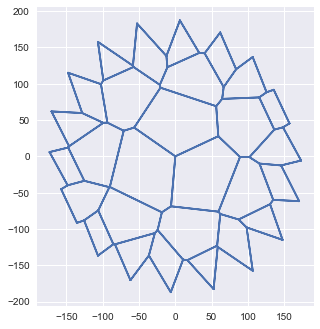

In [259]:
quick_edge_draw(loc_eptm)

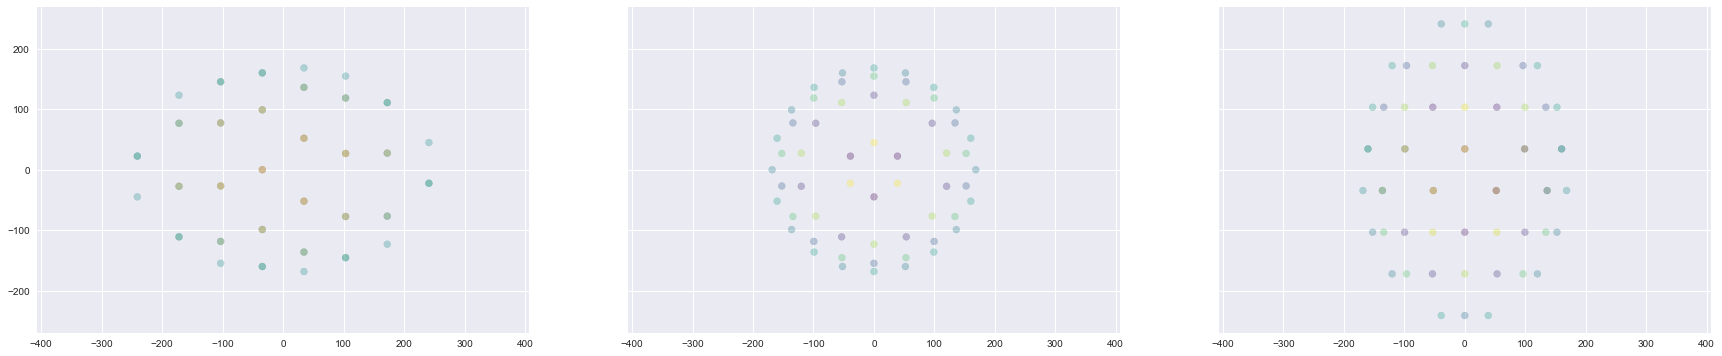

In [164]:
fig, axes = plt.subplots(1, 3, sharey=True, sharex=True)


fig.set_size_inches(30, 6)
axes[0].scatter(zs, xs, c=ys,
                alpha=0.3, cmap='viridis')
axes[1].scatter(ys, xs, c=zs,
                alpha=0.3, cmap='viridis')
axes[2].scatter(ys, zs, c=xs,
                alpha=0.3, cmap='viridis')

axes[0].set_aspect('equal')
axes[1].set_aspect('equal')
axes[2].set_aspect('equal')

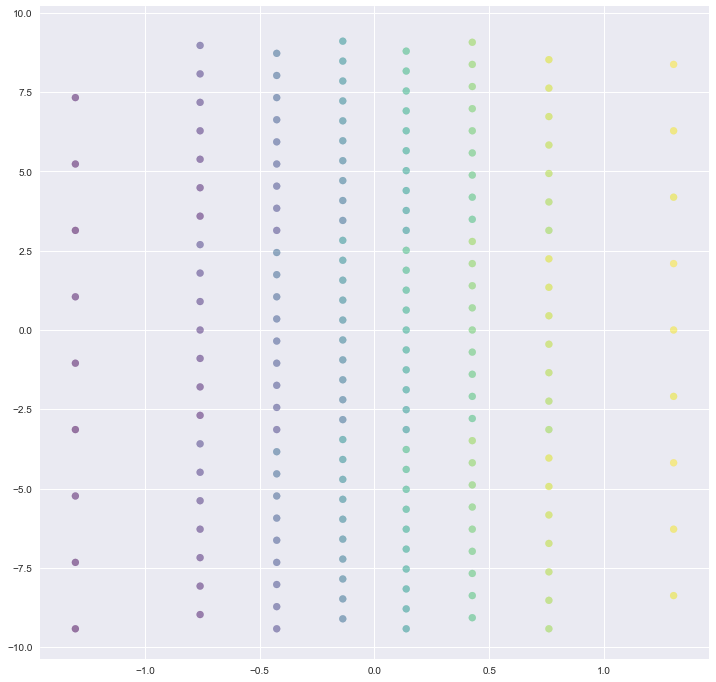

In [165]:
fig, ax = plt.subplots()
theta_shifts = [0,]
phi_shifts = [-2*np.pi, 0, 2*np.pi]
theta_shifts, phi_shifts = np.meshgrid(theta_shifts,
                                       phi_shifts)
for dtheta, dphi in zip(theta_shifts.ravel(),
                        phi_shifts.ravel()):

    ax.scatter(thetas+dtheta, phis+dphi, 
               alpha=0.5, c=np.arange(phis.size),
               cmap='viridis')

fig.set_size_inches(12, 12)

In [166]:
pbc_thetas = np.concatenate([thetas + shift for shift in theta_shifts.ravel()])
pbc_phis = np.concatenate([phis + shift for shift in phi_shifts.ravel()])
pbc_voro = Voronoi(np.vstack([pbc_thetas, pbc_phis]).T)

pbc_dsets = from_2d_voronoi(pbc_voro)

pbc_dsets['face']['f_ids'] = np.concatenate([np.arange(phis.size),]* phi_shifts.size)


pbc_eptm = Epithelium('theta_phi', pbc_dsets, config.geometry.flat_sheet())

from tyssue import PlanarGeometry
pbc_eptm.sanitize()

PlanarGeometry.update_all(pbc_eptm)

pbc_eptm.edge_df['sx'] = pbc_eptm.upcast_srce(pbc_eptm.vert_df['x'])
pbc_eptm.edge_df['sy'] = pbc_eptm.upcast_srce(pbc_eptm.vert_df['y'])

border = ((pbc_eptm.edge_df['sx'] < -1.8*np.pi) |
          (pbc_eptm.edge_df['sx'] > 1.8*np.pi) |
          (pbc_eptm.edge_df['sy'] < -1.8*np.pi) |
          (pbc_eptm.edge_df['sy'] > 1.8*np.pi))

to_remove = pbc_eptm.edge_df[border].index
pbc_eptm.remove(to_remove)

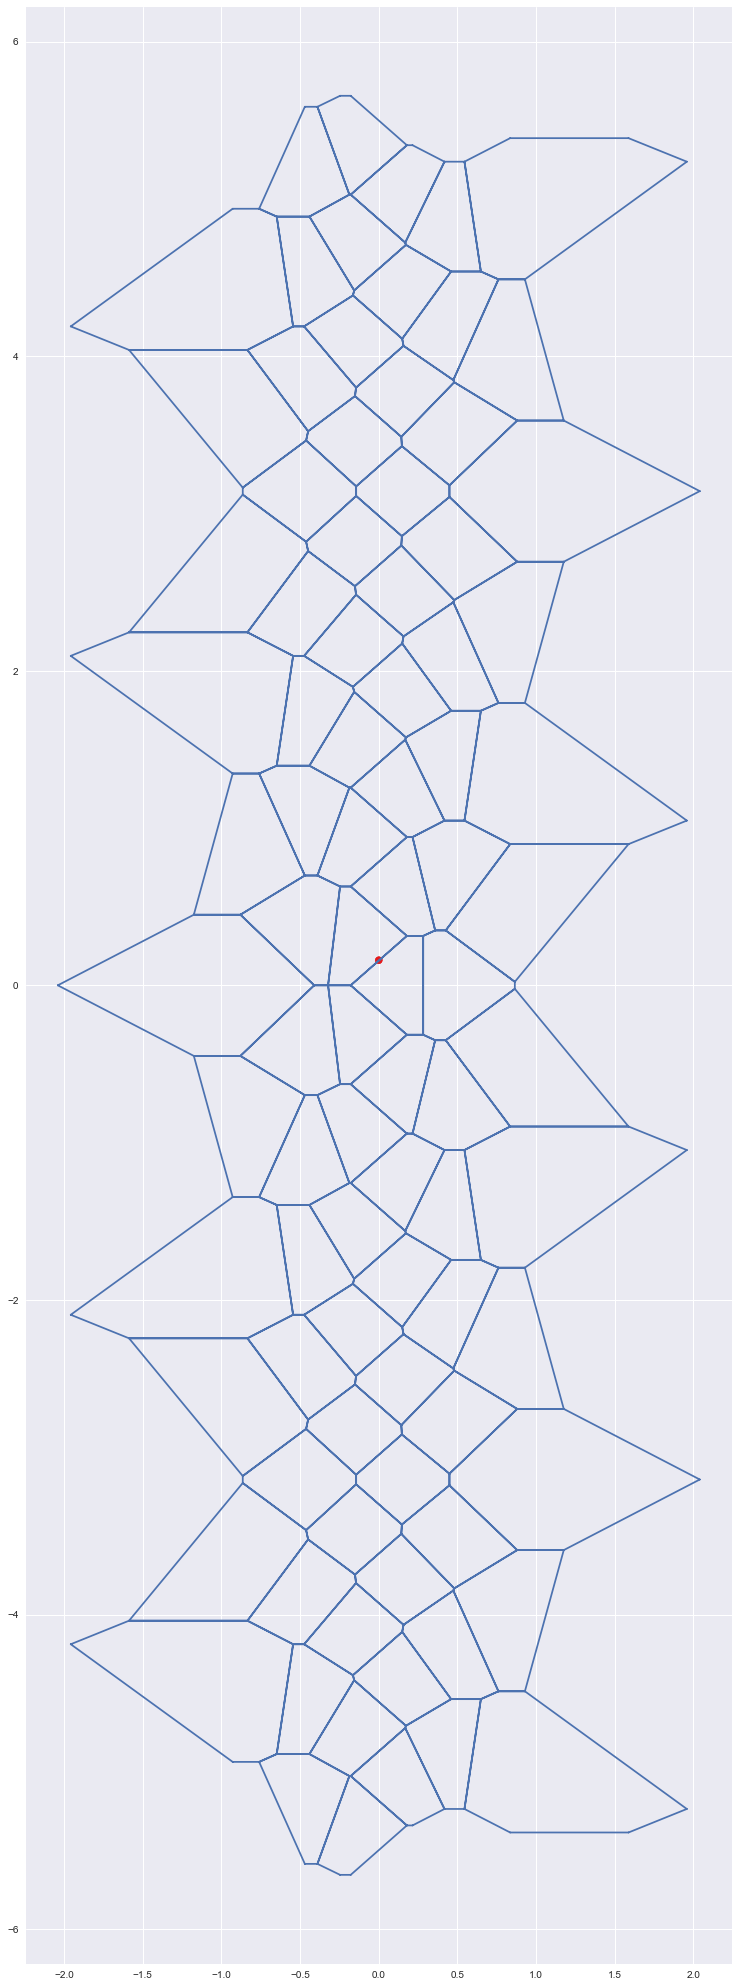

In [167]:
fdf = pbc_eptm.face_df[pbc_eptm.face_df.f_ids == 30]

fig, ax = quick_edge_draw(pbc_eptm,
                          coords=list('xy'))
ax.scatter(fdf.z, fdf.x,
           c=fdf.f_ids, cmap='Set1')

fig.set_size_inches(24, 36)

In [168]:
from tyssue.core.objects import get_opposite

In [169]:
pbc_eptm.vert_df['theta'] = pbc_eptm.vert_df['x']
pbc_eptm.vert_df['phi'] = pbc_eptm.vert_df['y']
pbc_eptm.vert_df['x'] = a * (np.cos(pbc_eptm.vert_df['theta']) *
                             np.cos(pbc_eptm.vert_df['phi']))
pbc_eptm.vert_df['y'] = b * (np.cos(pbc_eptm.vert_df['theta']) * 
                             np.sin(pbc_eptm.vert_df['phi']))
pbc_eptm.vert_df['z'] = c * np.sin(pbc_eptm.vert_df['theta'])



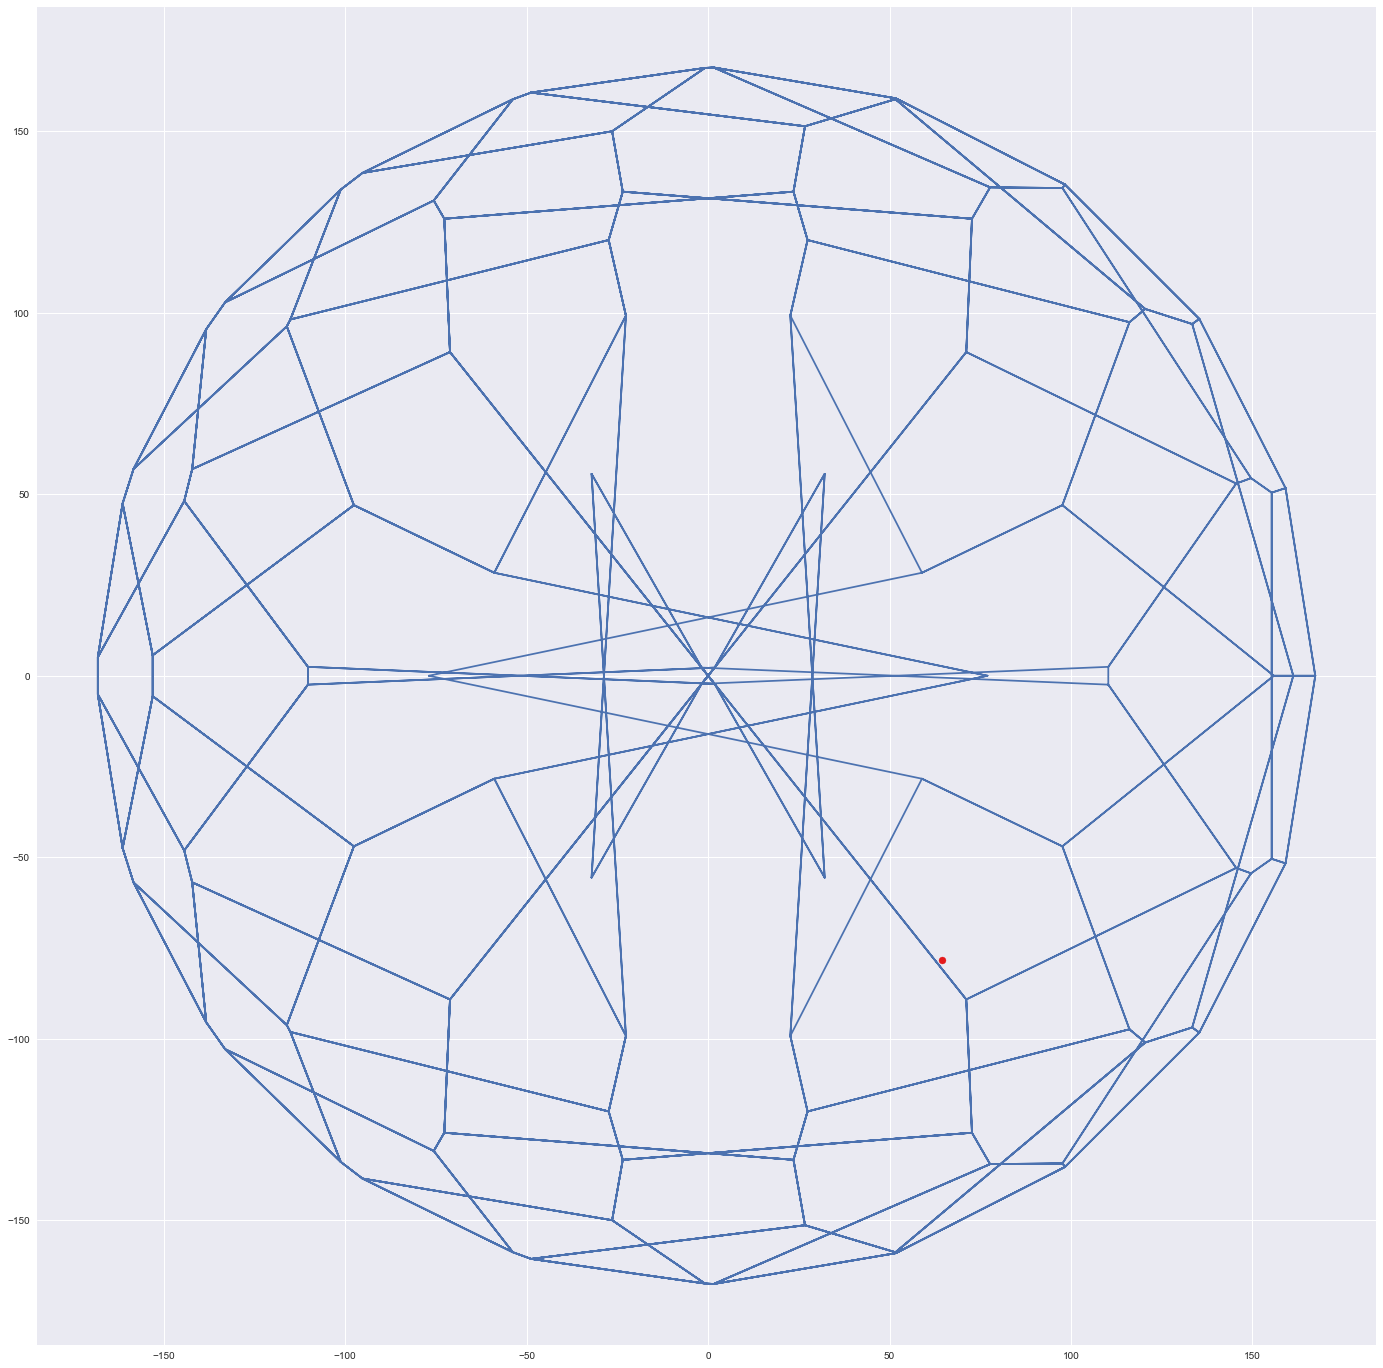

In [174]:
fdf = pbc_eptm.face_df[pbc_eptm.face_df.f_ids == 5]

fig, ax = quick_edge_draw(pbc_eptm,
                          coords=list('xy'))
ax.scatter(fdf.x, fdf.y,
           c=fdf.f_ids, cmap='Set1')

fig.set_size_inches(24, 36)

In [172]:
SheetGeometry.update_all(pbc_eptm)

In [173]:
render, scene = view_3js(pbc_eptm)

render

In [175]:
pbc_eptm.edge_df['f_ids'] = pbc_eptm.upcast_face(pbc_eptm.face_df.f_ids)


from tyssue.utils import data_at_opposite

pbc_eptm.edge_df['opposite'] = get_opposite(pbc_eptm.edge_df)
pbc_eptm.edge_df['opp_f_ids'] = data_at_opposite(pbc_eptm, pbc_eptm.edge_df['f_ids'])
pbc_eptm.vert_df['nv'] = -1
for i, (idx, vs) in enumerate(pbc_eptm.edge_df.groupby(['f_ids', 'opp_f_ids'])['srce']):
    pbc_eptm.vert_df.loc[list(vs), 'nv'] = i


In [176]:
from tyssue.utils import data_at_opposite

pbc_eptm.edge_df['opposite'] = get_opposite(pbc_eptm.edge_df)
pbc_eptm.edge_df['opp_f_ids'] = data_at_opposite(pbc_eptm, pbc_eptm.edge_df['f_ids'])
pbc_eptm.vert_df['nv'] = -1
for i, (idx, vs) in enumerate(pbc_eptm.edge_df.groupby(['f_ids', 'opp_f_ids'])['srce']):
    pbc_eptm.vert_df.loc[list(vs), 'nv'] = i


In [177]:
vert_df = pbc_eptm.vert_df.groupby('nv').mean()

vert_df.index.name = 'vert'
n_srce = pbc_eptm.upcast_srce(pbc_eptm.vert_df.nv)
n_trgt = pbc_eptm.upcast_trgt(pbc_eptm.vert_df.nv)
edge_df = pbc_eptm.edge_df[['srce', 'trgt', 'face']].copy()
edge_df['srce'] = n_srce
edge_df['trgt'] = n_trgt
edge_df['face'] = pbc_eptm.edge_df['f_ids']
face_df = pd.DataFrame(index=pbc_eptm.edge_df['f_ids'].unique(),
                       columns=[['x', 'y', 'z']])
face_df.index.name='face'


In [178]:
dsets = {'vert': vert_df,
         'face': face_df,
         'edge': edge_df}

eptm = Epithelium('embryo', datasets=dsets, 
                  specs=config.geometry.spherical_sheet())

In [179]:
from tyssue import SheetGeometry
SheetGeometry.update_all(eptm)

In [180]:
to_remove = eptm.edge_df[(eptm.edge_df.srce==-1) |
                         (eptm.edge_df.trgt==-1)].index
#eptm.remove(to_remove)

In [181]:
eptm.vert_df = eptm.vert_df.drop(-1)
eptm.edge_df = eptm.edge_df.loc[eptm.edge_df.index.delete(to_remove)]


In [182]:
from tyssue.topology.base_topology import close_face

In [183]:
close_face(eptm, face)

NameError: name 'face' is not defined

In [184]:
render, scene = view_3js(eptm)

render

In [185]:
from tyssue.dynamics import SheetModel
from tyssue.solvers.sheet_vertex_solver import Solver

In [219]:
from tyssue.utils import scaled_unscaled
dyn_specs = config.dynamics.quasistatic_sheet_spec()
dyn_specs['vert']['basal_shift'] = 150

dyn_specs['face']['prefered_vol'] = 120
dyn_specs['face']['contractility'] = 1.
dyn_specs['edge']['line_tension'] = 4.


eptm.update_specs(dyn_specs, reset=True)
SheetGeometry.update_all(eptm)

Reseting datasets values with new specs


In [220]:

eptm.face_df.vol

face
6     4.481486e+05
5     5.519606e+05
4     1.166751e+06
8     1.001438e+06
9     1.603101e+06
10    7.220822e+05
3     1.513101e+06
48    8.901419e+05
50    8.445463e+05
49    1.160273e+06
16    5.163876e+05
54    1.125810e+06
53    7.207801e+05
52    7.567724e+05
44    3.319540e+05
46    6.816820e+05
45    5.688068e+05
43    3.743959e+05
51    7.218643e+05
37    4.233354e+05
27    4.121260e+05
26    3.854009e+05
17    5.828089e+05
36    3.635899e+05
38    4.149259e+05
18    6.631268e+05
28    4.029226e+05
25    2.658268e+05
7     5.484288e+05
40    5.931477e+05
41    5.976590e+05
30    4.046472e+05
31    4.038953e+05
20    4.269343e+05
47    7.608971e+05
13    4.524557e+05
14    3.599460e+05
42    3.765175e+05
33    1.786208e+05
32    3.284217e+05
29    4.054473e+05
39    7.569389e+05
35    1.856129e+05
34    1.768587e+05
15    4.025733e+05
19    4.114750e+05
11    7.532037e+05
22    2.773217e+05
21    4.214441e+05
23    1.800060e+05
24    1.783658e+05
12    5.712207e+05
Name: v

In [228]:
scales = np.linspace(0.1, 1., 30)
nrjs = [scaled_unscaled(SheetModel.compute_energy,
                        scale, eptm, SheetGeometry, args=(eptm,))
        for scale in scales]

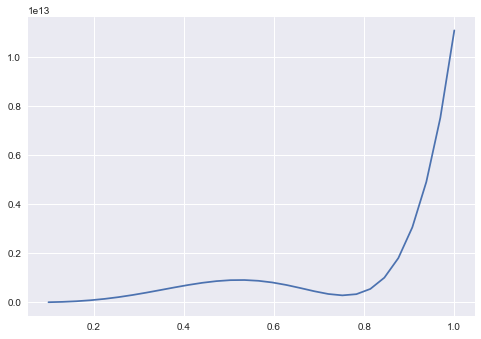

In [229]:
fig, ax = plt.subplots()
ax.plot(scales, nrjs)

In [230]:
SheetGeometry.scale(eptm, scales[np.argmin(nrjs[15:])+15], eptm.coords)

In [231]:
Solver.find_energy_min(eptm, SheetGeometry, SheetModel)

      fun: 3486046.7990308045
 hess_inv: <330x330 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -3.81289532e+03,  -2.81111237e+02,  -2.73891490e+03,
         5.20282351e+02,   7.71267441e+02,  -9.68083332e+02,
        -1.96193164e+01,   6.19506695e+02,   2.92506587e+02,
        -1.13453871e+03,   8.91765514e+02,   2.11759512e+03,
         3.29256647e+03,   2.60469564e+03,  -5.81636842e+03,
         1.29500591e+03,   5.01275947e+03,  -9.51103336e+03,
         4.80829121e+02,   1.78975050e+02,  -4.18698858e+02,
        -1.76347436e+03,   6.00135339e+02,  -2.33965910e+03,
        -3.40372466e+03,   4.40162704e+00,  -2.35417325e+03,
        -8.58208478e+02,  -1.57777373e+03,  -1.34020006e+03,
         1.23757312e+03,   2.78661315e+03,   5.62968977e+02,
         1.81939472e+02,   1.32522789e+02,  -3.07343515e+02,
         2.37669059e+02,   2.16014775e+03,   6.41184039e+02,
        -1.62141293e+03,   1.24685264e+03,   2.03159662e+03,
         4.08530321e+03,  -6.42582807e+03,  -

In [232]:
render, scene = view_3js(eptm)

render